In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

%matplotlib inline

### Create square market space

In [3]:
N = 100 # N * N square space

R = 1 # residents per square


M = np.ones((N,N,R), dtype = int)

OAs = {}
for i in range(N):
    OAs[i] = {}
    for j in range(N):
        OAs[i][j] = {'R' : R}

### Calculate Initial Number of Stores

In [4]:
O = 5 # operators
S = 100 # total number of stores
shares = [0.4, 0.28, 0.17, 0.1, 0.05]

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

class Store():
    
    def __init__(self, gsid, operator, x, y):
        self.gsid = gsid
        self.operator = operator
        self.x = x
        self.y = y

sr = 100
nstores = []
for operator in range(O):
    
    sn = int(S * shares[operator])
    nstores.append(sn)
    sr -= sn
    print operator, sn
    if sr != 0 and operator == O - 1:
        print 'Warning, incorrect number of exisitng stores, sr = %d' % sr

0 40
1 28
2 17
3 10
4 5


### Allocate stores

In [32]:
def random_alloction(O, nstores):
    gsid = 0
    stores = {}
    sigs = set()
    for operator in range(O):
        for n in range(nstores[operator]):
            while 1:
                x = np.random.randint(N-10) + 5
                y = np.random.randint(N-10) + 5
                sig = '%d%d' % (x,y)
                if sig not in sigs:
                    break
            sigs.add(sig)
            store = Store(gsid, operator, x, y)
            stores[gsid] = store
            gsid += 1
    return stores

def evolutionary_allocation(O, nstores, shares, rmin):
    gsid = 0
    stores = {}
    sigs = set()
    ns = {}
    total = sum(nstores)
    for operator in range(O):
        ns[operator] = 0
    n = 0
    while 1 :
        # pick operator at random, proportional to its final share
        operator = np.random.multinomial(1, shares).argmax()
        if ns[operator] >= nstores[operator]:
            continue
        while 1:
            x = np.random.randint(N-10) + 5
            y = np.random.randint(N-10) + 5
            found = 0
            for _x, _y in sigs:
                r = np.sqrt( np.power(_x-x, 2) + np.power(_y-y,2) )
                if r < rmin :
                    found = 1
                    break
            if found == 0:
                sigs.add((x,y))
                store = Store(gsid, operator, x, y)
                stores[gsid] = store
                gsid += 1
                ns[operator] += 1
                n += 1
                print gsid,
                break
        if n >= total:
            break
    print
    for operator in range(O):
        print operator, ns[operator]
    
    return stores

#stores = random_alloction(O, nstores)
#stores = evolutionary_allocation(O, nstores, shares, rmin = 7)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
0 40
1 28
2 17
3 10
4 5


### Create drivetime - Shortest drivetime to each operator

In [40]:

def calculate_agents_shortlist(N, OAs, stores):
    for i in range(N):
        for j in range(N):
            ops = {}
            for store in stores.values():
                r = np.sqrt( np.power(i - store.x,2 ) + np.power(j - store.y, 2) )
                #print i,j, store.operator, store.gsid, store.x, store.y, r, stores[store.gsid].x
                if store.operator not in ops :
                    ops[store.operator] = {'gsid' : store.gsid, 'r' : r, 'operator' : store.operator}
                if r < ops[store.operator]['r'] :
                    ops[store.operator] = {'gsid' : store.gsid, 'r' : r, 'operator' : store.operator}
                #print ops[store.operator]
                elif r == ops[store.operator]['r'] :
                    if np.random.rand() < 0.5 :
                        ops[store.operator] = {'gsid' : store.gsid, 'r' : r, 'operator' : store.operator}
            lops = []
            keys = ops.keys()
            keys.sort()
            lgsid = np.zeros(O, dtype = int)
            lr = np.zeros(O, dtype = float)
            lop = np.zeros(O, dtype = int)

            for k in keys :
                lops.append(ops[k])
                lgsid[k] = ops[k]['gsid']
                lr[k] = ops[k]['r']
                lop[k] = ops[k]['operator']

            OAs[i][j]['stores'] = {}
            OAs[i][j]['stores']['gsid'] = lgsid
            OAs[i][j]['stores']['r'] = lr
            OAs[i][j]['stores']['operator'] = lop
        
#calculate_agents_shortlist(N, OAs, stores)

### Calculate probabilities for nearest stores

In [60]:
def calculate_probability(N, OAs, r_exp, max_r):
    num_no_store = 0
    for i in range(N):
        for j in range(N):
            r = OAs[i][j]['stores']['r']
            rf = r < max_r
            prob = 1.0/np.power(r, r_exp) * rf
            if prob.sum() == 0.0 :
                num_no_store += 1
                prob = rf.astype(float)
            else:
                prob = prob / prob.sum()
            #print prob
            OAs[i][j]['stores']['prob'] = prob

    print 'Locations without operator:', num_no_store

#calculate_probability(N, OAs, r_exp = 2.0, max_r = 10.0)

### Init Sim

In [54]:
stores = evolutionary_allocation(O, nstores, shares, rmin = 7)
calculate_agents_shortlist(N, OAs, stores)
calculate_probability(N, OAs, r_exp = 2.0, max_r = 10.0)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
0 40
1 28
2 17
3 10
4 5
Locations without operator: 52


### Run Sim

In [55]:
T = 104
collector_gsid = {}
collector_operator = {}
for k in stores.keys():
    collector_gsid[k] = [0 for i in range(T)]
for op in range(O):
    collector_operator[op] = [0 for i in range(T)]

TP = 52    
    
for i in range(N):
        for j in range(N):
            OAs[i][j]['penetration'] = np.zeros((O,T), dtype = int)
            OAs[i][j]['penetration'].fill(-100)
    
for t in range(T):
    for i in range(N):
        for j in range(N):
            prob =  OAs[i][j]['stores']['prob']
            pos = -1
            if prob.sum() > 0:
                #pos = np.random.multinomial(1, prob).argmax()
                pos = prob.argmax()
                gsid =  OAs[i][j]['stores']['gsid'][pos]
                op =  OAs[i][j]['stores']['operator'][pos]

                collector_operator[op][t] += 1
                collector_gsid[gsid][t] += 1
            for op in range(O):
                if op != pos:
                    OAs[i][j]['penetration'][op][t] = OAs[i][j]['penetration'][op][t-1]
                else:
                    OAs[i][j]['penetration'][op][t] = t
            

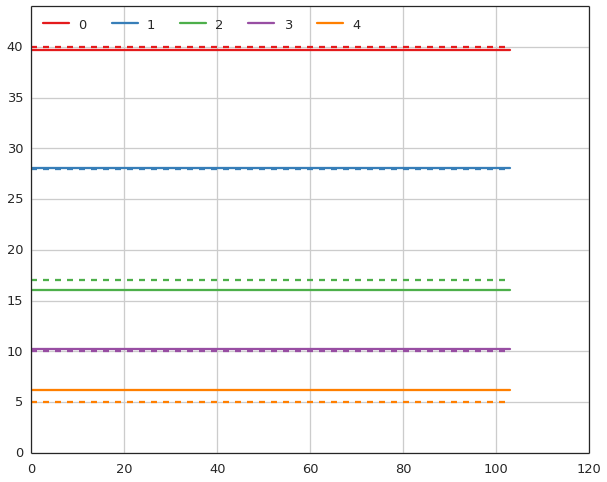

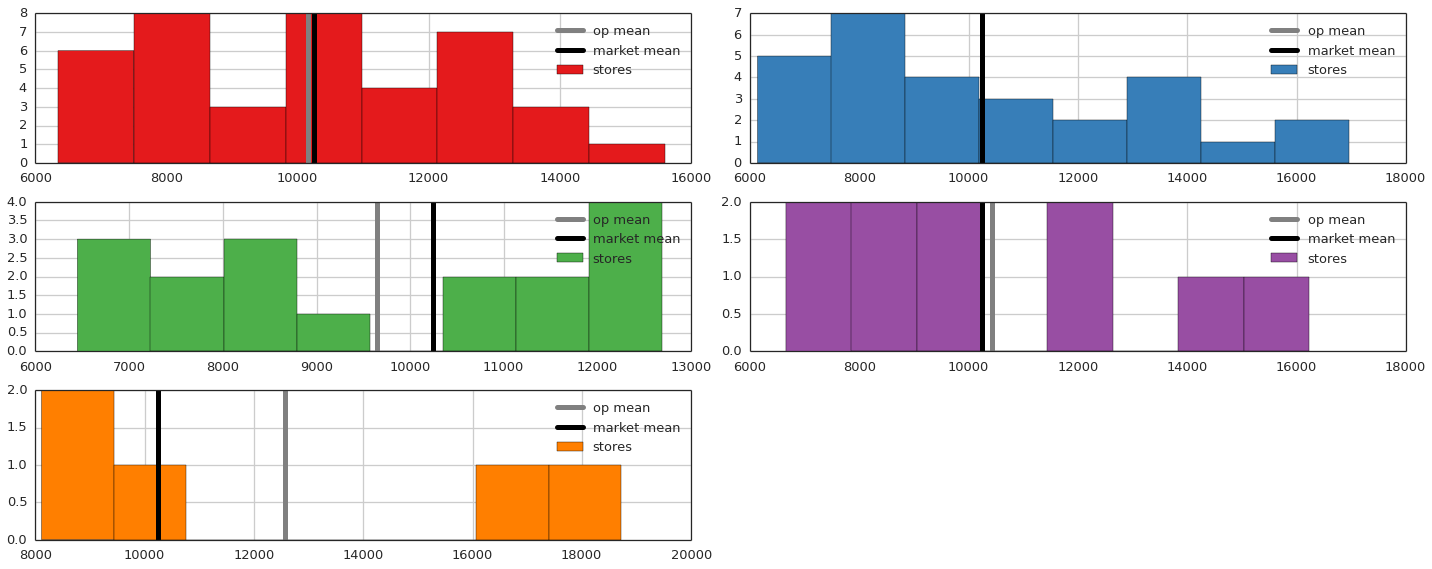

In [56]:
def plot_sim(T, N, collector_operator, collector_gsid, stores):
    fig, ax = plt.subplots(figsize = (10,8))
    ops = collector_operator.keys()
    ops.sort()
    
    total_sales = []
    for t in range(T):
        t_sales = 0
        for op in ops:
            t_sales += collector_operator[op][t]
        total_sales.append(t_sales)
    total_sales = np.asarray(total_sales, dtype = float)
    
    n = N*N * 1.0
    x = [t for t in range(T)]
    for op in ops:
        ax.plot(x, np.asarray(collector_operator[op]) / total_sales * 100, label = '%d' % op, color = colors[op])
        ax.plot(x, [100*shares[op] for i in range(T)], linestyle = '--', color = colors[op])
    
    ax.grid()
    ax.legend(loc = 2, ncol= len(ops))
    ax.set_ylim(0.0, max(shares) * 100*1.1)
    
    cols = 2
    rows = 3
    fig, axs = plt.subplots(rows, cols, figsize = (20,8))
    _axs = axs.reshape(-1)
    
    gsids = collector_gsid.keys()
    opss = {}
    op_stores = {}
    total_sales = 0.0
    
    for gsid in gsids :
        op = stores[gsid].operator
        if op not in opss:
            opss[op] = []
            op_stores[op] = []
            
        s = sum(collector_gsid[gsid])
        opss[op].append(s)
        op_stores[op].append(gsid)
        total_sales += s
    
    av_market_sales = total_sales / (1.0*len(gsids))
    
    for op in ops:
        df = pd.DataFrame({'store_sales' : opss[op], 'stores' : op_stores[op]})
        ax = _axs[op]
        df.store_sales.hist(bins = 8, ax=ax, color = colors[op], label = 'stores')
        av = df.store_sales.mean()
        ax.axvline(av, color = 'gray', label = 'op mean', linewidth = 5)
        ax.axvline(av_market_sales, color = 'k', linestyle = '-', label = 'market mean', linewidth = 5)
        ax.legend()
    fig.tight_layout()
    _axs[5].set_visible(False)
    
    

plot_sim(T, N, collector_operator, collector_gsid, stores)

2
31
20
93
3


(0, 100)

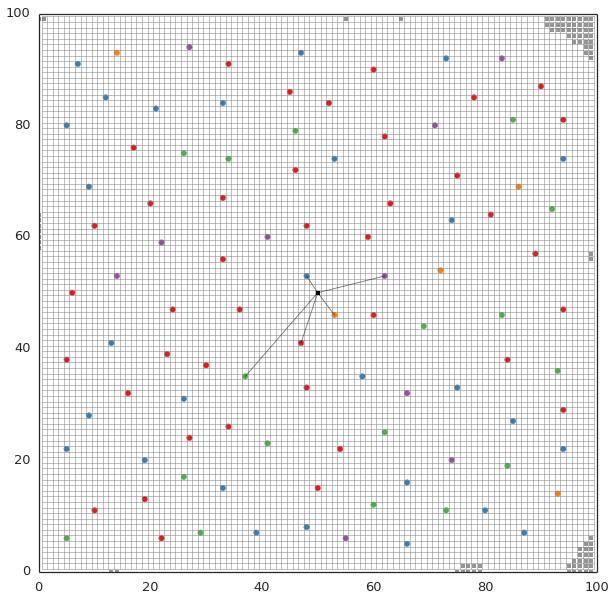

In [44]:
def plot_market(N, M, OAs, stores, ax):
    palette = sns.color_palette()
    for i in range(N):
        x = []
        y = []
        for j in range(N):
            r = M[i][j][0]
            #ax.scatter(i,j, marker = 'o')
            x.append(i+0.5)
            y.append(j+0.5)
            
            sprob = OAs[i][j]['stores']['prob'].sum()
            if sprob == 0.0: #No available operator to shop
                ax.plot([i,i],[j,j], marker = 's', color = 'gray', markersize = 4, alpha = 0.6)
                
        #ax.plot(x,y, color = palette[0])
        ax.plot(x,y, color = 'gray', linestyle = '-', linewidth = 0.5)
        ax.plot(y,x, color = 'gray', linestyle = '-', linewidth = 0.5)
        
    
    for store in stores.values():
        ax.scatter(store.x, store.y, color = colors[store.operator], s = 30)

def plot_oa_dt(i,j, ax):
    
    for gsid in OAs[i][j]['stores']['gsid']:
        print gsid
        x = stores[gsid].x
        y = stores[gsid].y
        ax.plot([i,x], [j, y], color = 'k', alpha = 0.5, linewidth = 0.9)
    ax.plot([i,i], [j,j], marker  = 's', markersize = 4, color = 'k')
        
fig, ax = plt.subplots(figsize=(10,10))
plot_market(N, M, OAs, stores, ax)

plot_oa_dt(50,50, ax)

ax.set_xlim(0,N)
ax.set_ylim(0,N)


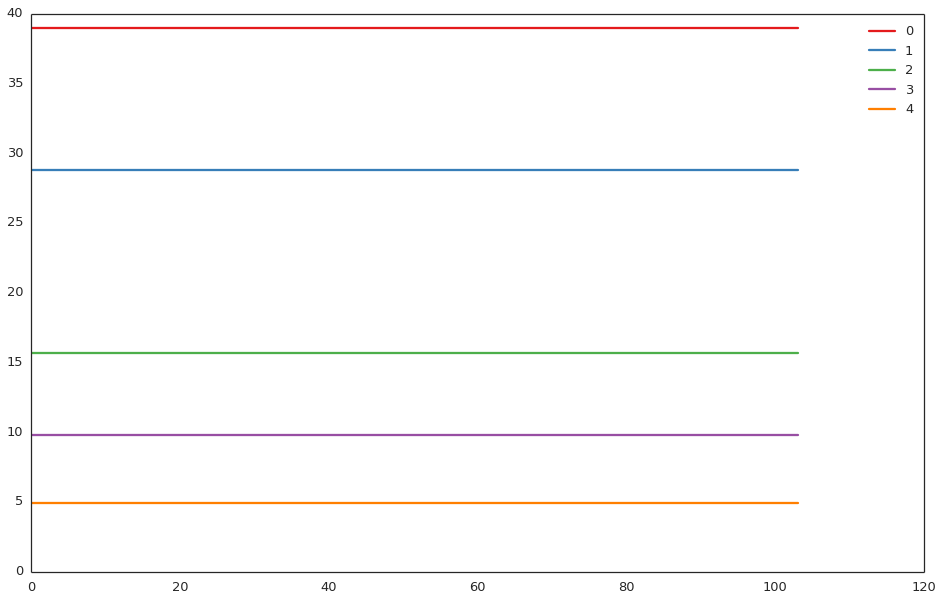

In [53]:
def plot_penetration(OAs, T, N, O):
    TP = 52
    d = {}
    f = 100.0 / (N*N)
    for op in range(O):
        y = []
        for t in range(T):
            n = 0
            for i in range(N):
                for j in range(N):
                    if t - OAs[i][j]['penetration'][op][t] < TP:
                        n += 1
            y.append(n * f)
        d[op] = y
    x = [t for t in range(T)]
    
    fig, ax = plt.subplots(figsize = (16,10))
    for op in range(O):
        ax.plot(x, d[op] , color = colors[op], label = '%d' % op)
    ax.legend()

plot_penetration(OAs, T, N, O) 

In [11]:
OAs[i][j]['stores']['gsid']

array([31, 55, 72, 90, 96])